# Time Series Analysis of Fire Data

This notebook analyzes historical fire data, explores trends, and fits time series models. It also examines relationships with solar activity.

## Imports and Data Cleaning

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# time series analysis
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Load the Excel file
excel_file = "../data/nbac_summarystats_1972_2023_20240530.xlsx"

df = pd.read_excel(excel_file, sheet_name='nbac_1972_2023_20240530')

# drop the first 3 rows and make the 4th row header
df.columns = df.iloc[3]
df = df.drop(index=[0, 1, 2, 3])
df = df.reset_index(drop=True)

# Convert columns to appropriate types
df['YEAR'] = df['YEAR'].astype(int)
df['ADJ_HA'] = df['ADJ_HA'].astype(float)

# make a column for before and after 2006
df['before_after_2006'] = df['YEAR'].apply(lambda x: 'before' if x <= 2006 else 'after')


In [2]:
# get percetage null for each column
def get_percentage_null(df):
    return df.isnull().sum() / len(df) * 100
percentage_null = get_percentage_null(df)
print(percentage_null)

3
YEAR                  0.000000
NFIREID               0.000000
BASRC                 0.000000
FIREMAPS              0.000000
FIREMAPM              0.000000
FIRECAUS              0.000000
HS_SDATE             72.226650
HS_EDATE             72.226650
AG_SDATE             23.439384
AG_EDATE             67.686303
CAPDATE              61.382537
POLY_HA               0.000000
ADJ_HA                0.000000
ADJ_FLAG             42.763440
ADMIN_AREA            0.000000
NATPARK              95.553648
PRESCRIBED           99.327735
VERSION               0.000000
GID                   0.000000
before_after_2006     0.000000
dtype: float64


In [4]:
df.columns

Index(['YEAR', 'NFIREID', 'BASRC', 'FIREMAPS', 'FIREMAPM', 'FIRECAUS',
       'HS_SDATE', 'HS_EDATE', 'AG_SDATE', 'AG_EDATE', 'CAPDATE', 'POLY_HA',
       'ADJ_HA', 'ADJ_FLAG', 'ADMIN_AREA', 'NATPARK', 'PRESCRIBED', 'VERSION',
       'GID', 'before_after_2006', 'HS_MID'],
      dtype='object', name=3)

In [5]:
# change the HS_EDATE AG_SDATE AG_EDATE CAPDATE columns to datetime
df['HS_EDATE'] = pd.to_datetime(df['HS_EDATE'], errors='coerce')
df['HS_SDATE'] = pd.to_datetime(df['HS_SDATE'], errors='coerce')
df['AG_SDATE'] = pd.to_datetime(df['AG_SDATE'], errors='coerce')
df['AG_EDATE'] = pd.to_datetime(df['AG_EDATE'], errors='coerce')
df['CAPDATE'] = pd.to_datetime(df['CAPDATE'], errors='coerce')

# make a new col for the middle of the AG_SDATE nd the AG_EDATE
df['HS_MID'] = (
    (df['HS_SDATE'].astype('int64') + df['HS_EDATE'].astype('int64')) // 2
).astype('datetime64[ns]')

# make a new col for the middle of the AG_SDATE nd the AG_EDATE
df['AG_MID'] = (
    (df['AG_SDATE'].astype('int64') + df['AG_EDATE'].astype('int64')) // 2
).astype('datetime64[ns]')

# change the AG_MID column to datetime
df['AG_MID'] = pd.to_datetime(df['AG_MID'], errors='coerce')

# make a new column for the month
df['month'] = df['AG_SDATE'].dt.month

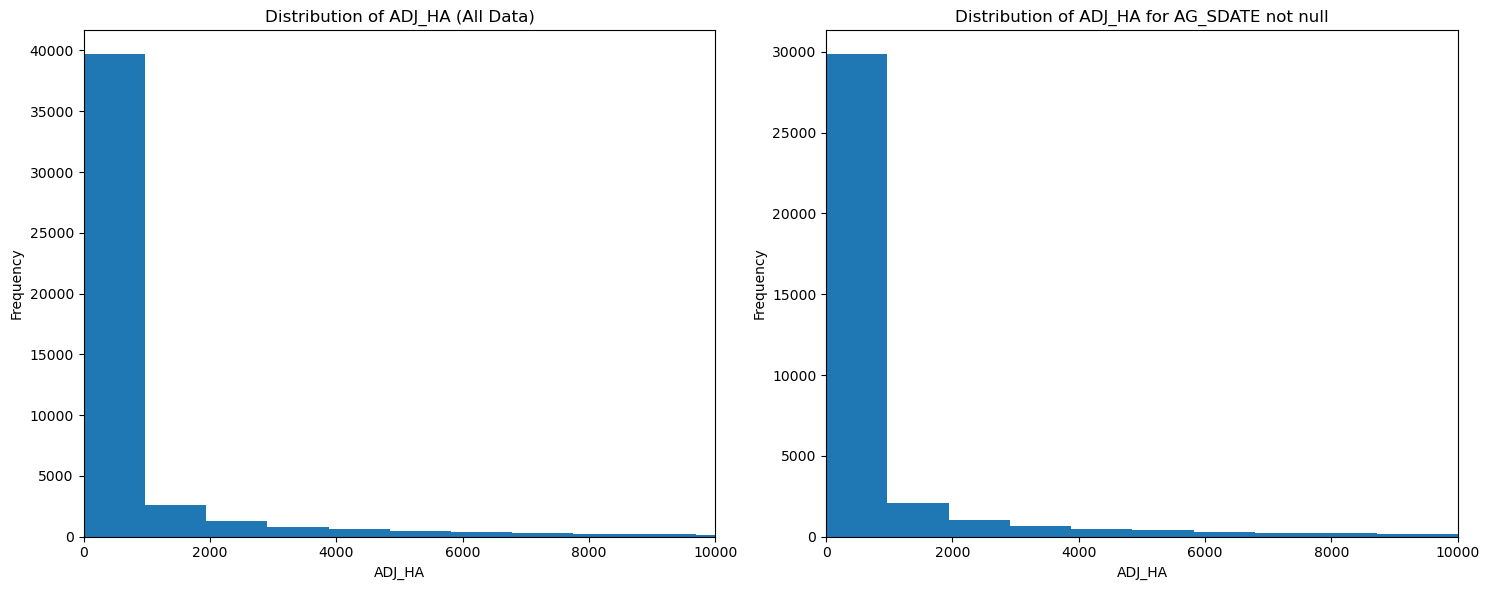

In [8]:
# see the distribtuion of ADJ_HA for the observations with null AG_SDATE
# Create side-by-side plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: Distribution of all ADJ_HA values
ax1.hist(df['ADJ_HA'].dropna(), bins=1000)
ax1.set_xlabel('ADJ_HA')
ax1.set_ylabel('Frequency')
ax1.set_title('Distribution of ADJ_HA (All Data)')
ax1.set_xlim(0, 10000)

# Plot 2: Distribution of ADJ_HA for observations with not null AG_SDATE
ax2.hist(df['ADJ_HA'][df['AG_SDATE'].notnull()], bins=1000)
ax2.set_xlabel('ADJ_HA')
ax2.set_ylabel('Frequency')
ax2.set_title('Distribution of ADJ_HA for AG_SDATE not null')
ax2.set_xlim(0, 10000)

plt.tight_layout()
plt.show()

## Sunspots Data

In [10]:
# sunspots data 

# import observed-solar-cycle-indices.json file 
import json

with open('../data/observed-solar-cycle-indices.json') as f:
    sunspots = json.load(f)

# convert to dataframe
sunspots_df = pd.DataFrame(sunspots)

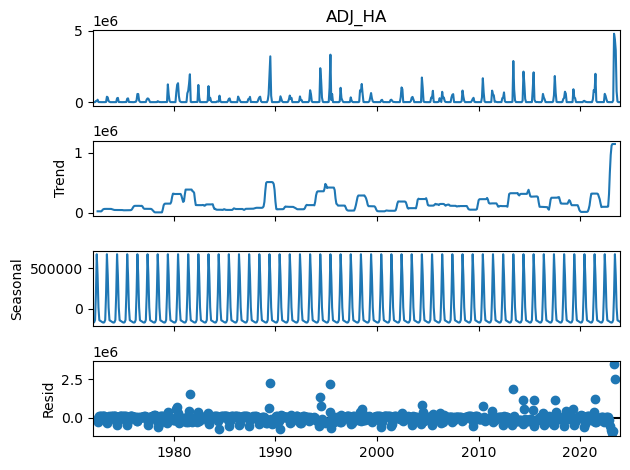

In [15]:
# select only the fires with a date
df_no_na = df[df['AG_SDATE'].notnull()]

# group by year and the month
df_grouped_nona = df_no_na.groupby(['YEAR', 'month']).agg({'ADJ_HA': 'sum'}).reset_index()

# for the missing months in the years add the rows and fill with 0
months = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
years = df_grouped_nona['YEAR'].unique()
# create a new dataframe with all the months and years
df_all_months = pd.DataFrame(
    [(year, month) for year in years for month in months],
    columns=['YEAR', 'month']
)
# merge the two dataframes
df_grouped_nona = pd.merge(
    df_all_months,
    df_grouped_nona,
    on=['YEAR', 'month'],
    how='left'
)
# fill the missing values with 0
df_grouped_nona['ADJ_HA'] = df_grouped_nona['ADJ_HA'].fillna(0)
# make a new column for the month
df_grouped_nona['month'] = df_grouped_nona['month'].astype(int)
# make a new column for the year
df_grouped_nona['YEAR'] = df_grouped_nona['YEAR'].astype(int)

# change time-tag to datetime from sunpots df
sunspots_df['time-tag'] = pd.to_datetime(sunspots_df['time-tag'], format='%Y-%m')

# subset the sunspots df to the years in the df_grouped_nona
sunspots_df = sunspots_df[sunspots_df['time-tag'].dt.year.isin(df_grouped_nona['YEAR'].unique())]

# make a new column for the month
x_exog = sunspots_df['ssn']

# time series of the burned area
y = df_grouped_nona['ADJ_HA']

# Ensure YEAR and month are combined into a datetime index
df_grouped_nona['date'] = pd.to_datetime(df_grouped_nona[['YEAR', 'month']].assign(day=1))
df_grouped_nona.set_index('date', inplace=True)

# Update y to use the datetime index
y = df_grouped_nona['ADJ_HA']

decomposition = seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

In [ ]:
# Define the search space.
p = range(1, 6)
d = range(0, 2)
q = range(0, 2)

# Create an interative list of ps, ds, qs.
from itertools import product
pdq = list(product(p, d, q))

# Seasonal parameters. One year back.
ps = range(0, 4)
ds = range(0, 1)
qs = range(0, 1)
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(product(ps, ds, qs))]

y = df_grouped_nona['ADJ_HA']

aic_out = []

for param in pdq:
  for param_seasonal in seasonal_pdq:
      mod = SARIMAX(y,
                    exog=np.asarray(x_exog),
                    order=param,
                    seasonal_order=param_seasonal,
                    enforce_stationarity=True,
                    enforce_invertibility=False
                    )
      results = mod.fit(verbose=False)
      aic_out.append([param, param_seasonal, results.aic])
      print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))

# Nicer formatting
aic_out = pd.DataFrame(aic_out,
                       columns = ['(p,q,r)', '(ps, qs, rs, S)', 'AIC'])

aic_out.sort_values(by='AIC', ascending=True)

c:\Users\LiW\AppData\Local\anaconda3\envs\poisson_fire\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\LiW\AppData\Local\anaconda3\envs\poisson_fire\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\LiW\AppData\Local\anaconda3\envs\poisson_fire\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: verbose. After release 0.14, this will raise.
  warnings.warn(


ARIMA(1, 0, 0)x(0, 0, 0, 12)12 - AIC:17915.717349620427


c:\Users\LiW\AppData\Local\anaconda3\envs\poisson_fire\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\LiW\AppData\Local\anaconda3\envs\poisson_fire\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\LiW\AppData\Local\anaconda3\envs\poisson_fire\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: verbose. After release 0.14, this will raise.
  warnings.warn(


ARIMA(1, 0, 0)x(1, 0, 0, 12)12 - AIC:17841.718083622596


c:\Users\LiW\AppData\Local\anaconda3\envs\poisson_fire\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\LiW\AppData\Local\anaconda3\envs\poisson_fire\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\LiW\AppData\Local\anaconda3\envs\poisson_fire\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: verbose. After release 0.14, this will raise.
  warnings.warn(


ARIMA(1, 0, 0)x(2, 0, 0, 12)12 - AIC:17820.370963806006


c:\Users\LiW\AppData\Local\anaconda3\envs\poisson_fire\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\LiW\AppData\Local\anaconda3\envs\poisson_fire\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\LiW\AppData\Local\anaconda3\envs\poisson_fire\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: verbose. After release 0.14, this will raise.
  warnings.warn(


ARIMA(1, 0, 0)x(3, 0, 0, 12)12 - AIC:17820.47509293876


c:\Users\LiW\AppData\Local\anaconda3\envs\poisson_fire\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\LiW\AppData\Local\anaconda3\envs\poisson_fire\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\LiW\AppData\Local\anaconda3\envs\poisson_fire\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: verbose. After release 0.14, this will raise.
  warnings.warn(


ARIMA(1, 0, 1)x(0, 0, 0, 12)12 - AIC:17909.09657166407


c:\Users\LiW\AppData\Local\anaconda3\envs\poisson_fire\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\LiW\AppData\Local\anaconda3\envs\poisson_fire\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\LiW\AppData\Local\anaconda3\envs\poisson_fire\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: verbose. After release 0.14, this will raise.
  warnings.warn(


ARIMA(1, 0, 1)x(1, 0, 0, 12)12 - AIC:17840.79761245953


c:\Users\LiW\AppData\Local\anaconda3\envs\poisson_fire\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\LiW\AppData\Local\anaconda3\envs\poisson_fire\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\LiW\AppData\Local\anaconda3\envs\poisson_fire\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: verbose. After release 0.14, this will raise.
  warnings.warn(


ARIMA(1, 0, 1)x(2, 0, 0, 12)12 - AIC:17819.46614376959


c:\Users\LiW\AppData\Local\anaconda3\envs\poisson_fire\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\LiW\AppData\Local\anaconda3\envs\poisson_fire\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\LiW\AppData\Local\anaconda3\envs\poisson_fire\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: verbose. After release 0.14, this will raise.
  warnings.warn(


ARIMA(1, 0, 1)x(3, 0, 0, 12)12 - AIC:17820.024098545233
ARIMA(1, 1, 0)x(0, 0, 0, 12)12 - AIC:18043.681876866784


c:\Users\LiW\AppData\Local\anaconda3\envs\poisson_fire\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\LiW\AppData\Local\anaconda3\envs\poisson_fire\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\LiW\AppData\Local\anaconda3\envs\poisson_fire\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: verbose. After release 0.14, this will raise.
  warnings.warn(
c:\Users\LiW\AppData\Local\anaconda3\envs\poisson_fire\Lib\site-package

ARIMA(1, 1, 0)x(1, 0, 0, 12)12 - AIC:17971.640378543834


c:\Users\LiW\AppData\Local\anaconda3\envs\poisson_fire\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\LiW\AppData\Local\anaconda3\envs\poisson_fire\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\LiW\AppData\Local\anaconda3\envs\poisson_fire\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: verbose. After release 0.14, this will raise.
  warnings.warn(


ARIMA(1, 1, 0)x(2, 0, 0, 12)12 - AIC:17953.552325166784


c:\Users\LiW\AppData\Local\anaconda3\envs\poisson_fire\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\LiW\AppData\Local\anaconda3\envs\poisson_fire\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\LiW\AppData\Local\anaconda3\envs\poisson_fire\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: verbose. After release 0.14, this will raise.
  warnings.warn(


ARIMA(1, 1, 0)x(3, 0, 0, 12)12 - AIC:17952.075892714704


c:\Users\LiW\AppData\Local\anaconda3\envs\poisson_fire\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\LiW\AppData\Local\anaconda3\envs\poisson_fire\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\LiW\AppData\Local\anaconda3\envs\poisson_fire\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\LiW\AppData\Local\anaconda3\envs\poisson_fire\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbf

ARIMA(1, 1, 1)x(0, 0, 0, 12)12 - AIC:17898.953340526183


c:\Users\LiW\AppData\Local\anaconda3\envs\poisson_fire\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\LiW\AppData\Local\anaconda3\envs\poisson_fire\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\LiW\AppData\Local\anaconda3\envs\poisson_fire\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\LiW\AppData\Local\anaconda3\envs\poisson_fire\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbf

ARIMA(1, 1, 1)x(1, 0, 0, 12)12 - AIC:17840.104764648066


c:\Users\LiW\AppData\Local\anaconda3\envs\poisson_fire\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\LiW\AppData\Local\anaconda3\envs\poisson_fire\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\LiW\AppData\Local\anaconda3\envs\poisson_fire\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\LiW\AppData\Local\anaconda3\envs\poisson_fire\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbf

ARIMA(1, 1, 1)x(2, 0, 0, 12)12 - AIC:17822.833346108793


c:\Users\LiW\AppData\Local\anaconda3\envs\poisson_fire\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\LiW\AppData\Local\anaconda3\envs\poisson_fire\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\LiW\AppData\Local\anaconda3\envs\poisson_fire\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\LiW\AppData\Local\anaconda3\envs\poisson_fire\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbf

ARIMA(1, 1, 1)x(3, 0, 0, 12)12 - AIC:17823.0567219375
ARIMA(2, 0, 0)x(0, 0, 0, 12)12 - AIC:17905.77053828112


c:\Users\LiW\AppData\Local\anaconda3\envs\poisson_fire\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\LiW\AppData\Local\anaconda3\envs\poisson_fire\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\LiW\AppData\Local\anaconda3\envs\poisson_fire\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: verbose. After release 0.14, this will raise.
  warnings.warn(
c:\Users\LiW\AppData\Local\anaconda3\envs\poisson_fire\Lib\site-package

ARIMA(2, 0, 0)x(1, 0, 0, 12)12 - AIC:17839.23427942322


c:\Users\LiW\AppData\Local\anaconda3\envs\poisson_fire\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\LiW\AppData\Local\anaconda3\envs\poisson_fire\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\LiW\AppData\Local\anaconda3\envs\poisson_fire\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: verbose. After release 0.14, this will raise.
  warnings.warn(


ARIMA(2, 0, 0)x(2, 0, 0, 12)12 - AIC:17817.975618457815


c:\Users\LiW\AppData\Local\anaconda3\envs\poisson_fire\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\LiW\AppData\Local\anaconda3\envs\poisson_fire\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\LiW\AppData\Local\anaconda3\envs\poisson_fire\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: verbose. After release 0.14, this will raise.
  warnings.warn(


ARIMA(2, 0, 0)x(3, 0, 0, 12)12 - AIC:17818.597737933436


c:\Users\LiW\AppData\Local\anaconda3\envs\poisson_fire\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\LiW\AppData\Local\anaconda3\envs\poisson_fire\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\LiW\AppData\Local\anaconda3\envs\poisson_fire\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: verbose. After release 0.14, this will raise.
  warnings.warn(


ARIMA(2, 0, 1)x(0, 0, 0, 12)12 - AIC:17901.39601400697


c:\Users\LiW\AppData\Local\anaconda3\envs\poisson_fire\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\LiW\AppData\Local\anaconda3\envs\poisson_fire\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\LiW\AppData\Local\anaconda3\envs\poisson_fire\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: verbose. After release 0.14, this will raise.
  warnings.warn(


ARIMA(2, 0, 1)x(1, 0, 0, 12)12 - AIC:17837.28896268464


c:\Users\LiW\AppData\Local\anaconda3\envs\poisson_fire\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\LiW\AppData\Local\anaconda3\envs\poisson_fire\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\LiW\AppData\Local\anaconda3\envs\poisson_fire\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: verbose. After release 0.14, this will raise.
  warnings.warn(


ARIMA(2, 0, 1)x(2, 0, 0, 12)12 - AIC:17817.587846543112


c:\Users\LiW\AppData\Local\anaconda3\envs\poisson_fire\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\LiW\AppData\Local\anaconda3\envs\poisson_fire\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\LiW\AppData\Local\anaconda3\envs\poisson_fire\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: verbose. After release 0.14, this will raise.
  warnings.warn(


ARIMA(2, 0, 1)x(3, 0, 0, 12)12 - AIC:17818.28067523621
ARIMA(2, 1, 0)x(0, 0, 0, 12)12 - AIC:18028.440230546345


c:\Users\LiW\AppData\Local\anaconda3\envs\poisson_fire\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\LiW\AppData\Local\anaconda3\envs\poisson_fire\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\LiW\AppData\Local\anaconda3\envs\poisson_fire\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: verbose. After release 0.14, this will raise.
  warnings.warn(
c:\Users\LiW\AppData\Local\anaconda3\envs\poisson_fire\Lib\site-package

ARIMA(2, 1, 0)x(1, 0, 0, 12)12 - AIC:17956.419145074065


c:\Users\LiW\AppData\Local\anaconda3\envs\poisson_fire\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\LiW\AppData\Local\anaconda3\envs\poisson_fire\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\LiW\AppData\Local\anaconda3\envs\poisson_fire\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: verbose. After release 0.14, this will raise.
  warnings.warn(


ARIMA(2, 1, 0)x(2, 0, 0, 12)12 - AIC:17933.132215281235


c:\Users\LiW\AppData\Local\anaconda3\envs\poisson_fire\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\LiW\AppData\Local\anaconda3\envs\poisson_fire\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\LiW\AppData\Local\anaconda3\envs\poisson_fire\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: verbose. After release 0.14, this will raise.
  warnings.warn(


ARIMA(2, 1, 0)x(3, 0, 0, 12)12 - AIC:17932.949915828023


c:\Users\LiW\AppData\Local\anaconda3\envs\poisson_fire\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\LiW\AppData\Local\anaconda3\envs\poisson_fire\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\LiW\AppData\Local\anaconda3\envs\poisson_fire\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\LiW\AppData\Local\anaconda3\envs\poisson_fire\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbf

ARIMA(2, 1, 1)x(0, 0, 0, 12)12 - AIC:17888.6589330539


c:\Users\LiW\AppData\Local\anaconda3\envs\poisson_fire\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\LiW\AppData\Local\anaconda3\envs\poisson_fire\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\LiW\AppData\Local\anaconda3\envs\poisson_fire\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\LiW\AppData\Local\anaconda3\envs\poisson_fire\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbf

ARIMA(2, 1, 1)x(1, 0, 0, 12)12 - AIC:17838.643574624766


c:\Users\LiW\AppData\Local\anaconda3\envs\poisson_fire\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\LiW\AppData\Local\anaconda3\envs\poisson_fire\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\LiW\AppData\Local\anaconda3\envs\poisson_fire\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\LiW\AppData\Local\anaconda3\envs\poisson_fire\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbf

ARIMA(2, 1, 1)x(2, 0, 0, 12)12 - AIC:17822.0231180169


c:\Users\LiW\AppData\Local\anaconda3\envs\poisson_fire\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\LiW\AppData\Local\anaconda3\envs\poisson_fire\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\LiW\AppData\Local\anaconda3\envs\poisson_fire\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\LiW\AppData\Local\anaconda3\envs\poisson_fire\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbf

ARIMA(2, 1, 1)x(3, 0, 0, 12)12 - AIC:17822.80348878009
ARIMA(3, 0, 0)x(0, 0, 0, 12)12 - AIC:17902.255048591505


c:\Users\LiW\AppData\Local\anaconda3\envs\poisson_fire\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\LiW\AppData\Local\anaconda3\envs\poisson_fire\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\LiW\AppData\Local\anaconda3\envs\poisson_fire\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: verbose. After release 0.14, this will raise.
  warnings.warn(
c:\Users\LiW\AppData\Local\anaconda3\envs\poisson_fire\Lib\site-package

ARIMA(3, 0, 0)x(1, 0, 0, 12)12 - AIC:17837.163303853544


c:\Users\LiW\AppData\Local\anaconda3\envs\poisson_fire\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\LiW\AppData\Local\anaconda3\envs\poisson_fire\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\LiW\AppData\Local\anaconda3\envs\poisson_fire\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: verbose. After release 0.14, this will raise.
  warnings.warn(


ARIMA(3, 0, 0)x(2, 0, 0, 12)12 - AIC:17817.87258717211


c:\Users\LiW\AppData\Local\anaconda3\envs\poisson_fire\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\LiW\AppData\Local\anaconda3\envs\poisson_fire\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\LiW\AppData\Local\anaconda3\envs\poisson_fire\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: verbose. After release 0.14, this will raise.
  warnings.warn(


ARIMA(3, 0, 0)x(3, 0, 0, 12)12 - AIC:17818.36710062618


c:\Users\LiW\AppData\Local\anaconda3\envs\poisson_fire\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\LiW\AppData\Local\anaconda3\envs\poisson_fire\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\LiW\AppData\Local\anaconda3\envs\poisson_fire\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: verbose. After release 0.14, this will raise.
  warnings.warn(


ARIMA(3, 0, 1)x(0, 0, 0, 12)12 - AIC:17903.331842587184


c:\Users\LiW\AppData\Local\anaconda3\envs\poisson_fire\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\LiW\AppData\Local\anaconda3\envs\poisson_fire\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\LiW\AppData\Local\anaconda3\envs\poisson_fire\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: verbose. After release 0.14, this will raise.
  warnings.warn(


ARIMA(3, 0, 1)x(1, 0, 0, 12)12 - AIC:17839.003124585277


c:\Users\LiW\AppData\Local\anaconda3\envs\poisson_fire\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\LiW\AppData\Local\anaconda3\envs\poisson_fire\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\LiW\AppData\Local\anaconda3\envs\poisson_fire\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: verbose. After release 0.14, this will raise.
  warnings.warn(


ARIMA(3, 0, 1)x(2, 0, 0, 12)12 - AIC:17819.549981784097


c:\Users\LiW\AppData\Local\anaconda3\envs\poisson_fire\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\LiW\AppData\Local\anaconda3\envs\poisson_fire\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\LiW\AppData\Local\anaconda3\envs\poisson_fire\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: verbose. After release 0.14, this will raise.
  warnings.warn(


ARIMA(3, 0, 1)x(3, 0, 0, 12)12 - AIC:17820.17741431934
ARIMA(3, 1, 0)x(0, 0, 0, 12)12 - AIC:18001.313472020483


c:\Users\LiW\AppData\Local\anaconda3\envs\poisson_fire\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\LiW\AppData\Local\anaconda3\envs\poisson_fire\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\LiW\AppData\Local\anaconda3\envs\poisson_fire\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: verbose. After release 0.14, this will raise.
  warnings.warn(
c:\Users\LiW\AppData\Local\anaconda3\envs\poisson_fire\Lib\site-package

ARIMA(3, 1, 0)x(1, 0, 0, 12)12 - AIC:17932.13878615431


c:\Users\LiW\AppData\Local\anaconda3\envs\poisson_fire\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\LiW\AppData\Local\anaconda3\envs\poisson_fire\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\LiW\AppData\Local\anaconda3\envs\poisson_fire\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: verbose. After release 0.14, this will raise.
  warnings.warn(


ARIMA(3, 1, 0)x(2, 0, 0, 12)12 - AIC:17911.679252213682


c:\Users\LiW\AppData\Local\anaconda3\envs\poisson_fire\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\LiW\AppData\Local\anaconda3\envs\poisson_fire\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\LiW\AppData\Local\anaconda3\envs\poisson_fire\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: verbose. After release 0.14, this will raise.
  warnings.warn(


ARIMA(3, 1, 0)x(3, 0, 0, 12)12 - AIC:17911.113097831276


c:\Users\LiW\AppData\Local\anaconda3\envs\poisson_fire\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\LiW\AppData\Local\anaconda3\envs\poisson_fire\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\LiW\AppData\Local\anaconda3\envs\poisson_fire\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: verbose. After release 0.14, this will raise.
  warnings.warn(


ARIMA(3, 1, 1)x(0, 0, 0, 12)12 - AIC:17884.14507342621


c:\Users\LiW\AppData\Local\anaconda3\envs\poisson_fire\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\LiW\AppData\Local\anaconda3\envs\poisson_fire\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\LiW\AppData\Local\anaconda3\envs\poisson_fire\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: verbose. After release 0.14, this will raise.
  warnings.warn(


ARIMA(3, 1, 1)x(1, 0, 0, 12)12 - AIC:17836.834810937922


c:\Users\LiW\AppData\Local\anaconda3\envs\poisson_fire\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\LiW\AppData\Local\anaconda3\envs\poisson_fire\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\LiW\AppData\Local\anaconda3\envs\poisson_fire\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: verbose. After release 0.14, this will raise.
  warnings.warn(


ARIMA(3, 1, 1)x(2, 0, 0, 12)12 - AIC:17822.439279662398


c:\Users\LiW\AppData\Local\anaconda3\envs\poisson_fire\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\LiW\AppData\Local\anaconda3\envs\poisson_fire\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\LiW\AppData\Local\anaconda3\envs\poisson_fire\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: verbose. After release 0.14, this will raise.
  warnings.warn(


ARIMA(3, 1, 1)x(3, 0, 0, 12)12 - AIC:17823.109360539034
ARIMA(4, 0, 0)x(0, 0, 0, 12)12 - AIC:17904.085929729852


c:\Users\LiW\AppData\Local\anaconda3\envs\poisson_fire\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\LiW\AppData\Local\anaconda3\envs\poisson_fire\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\LiW\AppData\Local\anaconda3\envs\poisson_fire\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: verbose. After release 0.14, this will raise.
  warnings.warn(
c:\Users\LiW\AppData\Local\anaconda3\envs\poisson_fire\Lib\site-package

ARIMA(4, 0, 0)x(1, 0, 0, 12)12 - AIC:17839.068424490066


c:\Users\LiW\AppData\Local\anaconda3\envs\poisson_fire\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\LiW\AppData\Local\anaconda3\envs\poisson_fire\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\LiW\AppData\Local\anaconda3\envs\poisson_fire\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: verbose. After release 0.14, this will raise.
  warnings.warn(


In [79]:
# Fit the SARIMAX model
mod = SARIMAX(y, exog=np.asarray(x_exog), order=(2, 0, 1), seasonal_order=(2, 0, 0, 12))
results = mod.fit()

# Print the summary
print(results.summary())

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.42823D+01    |proj g|=  8.63759D-02

At iterate    5    f=  1.42658D+01    |proj g|=  5.09485D-04

At iterate   10    f=  1.42657D+01    |proj g|=  3.58214D-03

At iterate   15    f=  1.42657D+01    |proj g|=  3.90232D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     15     18      1     0     0   3.902D-05   1.427D+01
  F =   14.265695389130519     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
        

## Analysis of Significant Years

## 2023 

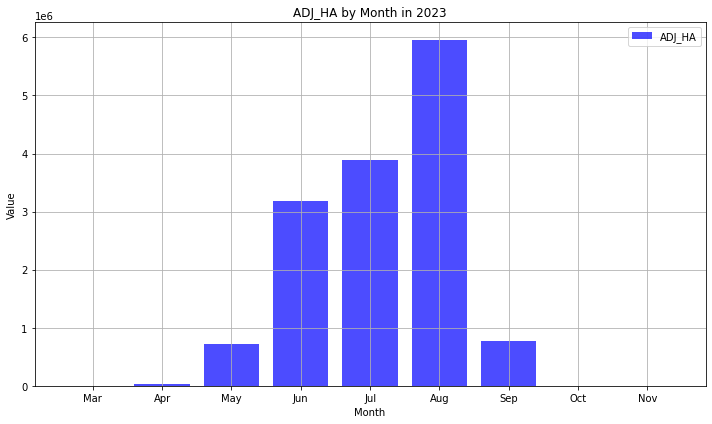

In [33]:
df_2023 = df[df['YEAR'] == 2023]

# drop the rows with null values in HS_SDATE or HS_EDATE
df_2023 = df_2023.dropna(subset=['HS_SDATE', 'HS_EDATE'])

# group by the month 
df_2023_grouped = df_2023.groupby('month').agg(
    {'ADJ_HA': 'sum', 'HS_MID': 'count'}
).reset_index()

df_2023_grouped

# plot the data
plt.figure(figsize=(10, 6))
plt.bar(df_2023_grouped['month'], df_2023_grouped['ADJ_HA'], color='blue', alpha=0.7, label='ADJ_HA')
plt.title('ADJ_HA by Month in 2023')
plt.xlabel('Month')
plt.ylabel('Value')
plt.xticks(df_2023_grouped['month'], ['Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov'])
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

## 1997

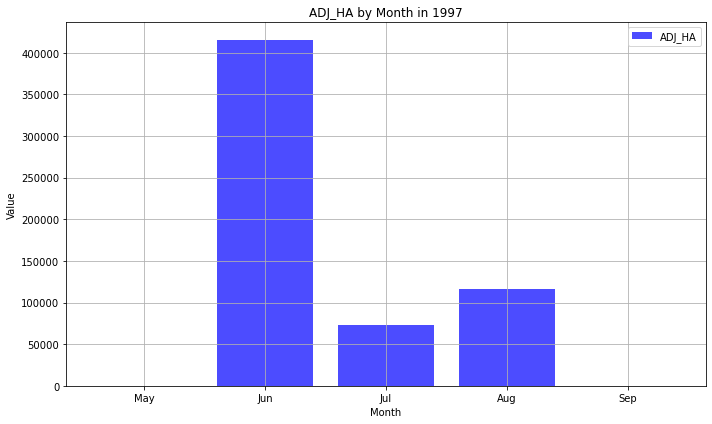

In [37]:
df_2023 = df[df['YEAR'] == 1997]

# drop the rows with null values in HS_SDATE or HS_EDATE
df_2023 = df_2023.dropna(subset=['HS_SDATE', 'HS_EDATE'])

# group by the month 
df_2023_grouped = df_2023.groupby('month').agg(
    {'ADJ_HA': 'sum', 'HS_MID': 'count'}
).reset_index()

df_2023_grouped

# plot the data
plt.figure(figsize=(10, 6))
plt.bar(df_2023_grouped['month'], df_2023_grouped['ADJ_HA'], color='blue', alpha=0.7, label='ADJ_HA')
plt.title('ADJ_HA by Month in 1997')
plt.xlabel('Month')
plt.ylabel('Value')
plt.xticks(df_2023_grouped['month'], ['May', 'Jun', 'Jul', 'Aug', 'Sep'])
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

## 1989

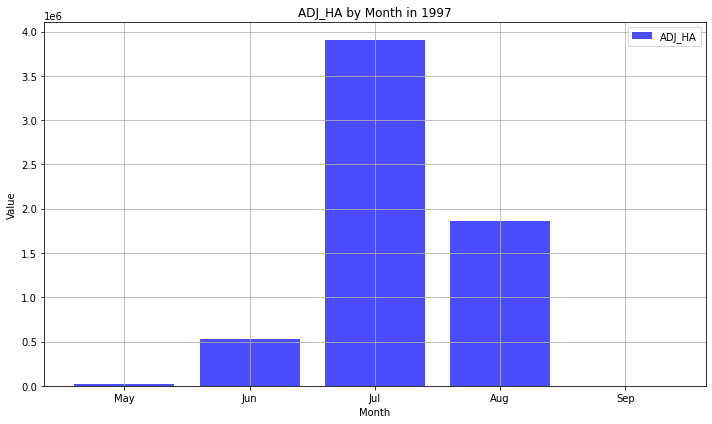

In [36]:
df_2023 = df[df['YEAR'] == 1989]

# drop the rows with null values in HS_SDATE or HS_EDATE
df_2023 = df_2023.dropna(subset=['HS_SDATE', 'HS_EDATE'])

# group by the month 
df_2023_grouped = df_2023.groupby('month').agg(
    {'ADJ_HA': 'sum', 'HS_MID': 'count'}
).reset_index()

df_2023_grouped

# plot the data
plt.figure(figsize=(10, 6))
plt.bar(df_2023_grouped['month'], df_2023_grouped['ADJ_HA'], color='blue', alpha=0.7, label='ADJ_HA')
plt.title('ADJ_HA by Month in 1997')
plt.xlabel('Month')
plt.ylabel('Value')
plt.xticks(df_2023_grouped['month'], ['May', 'Jun', 'Jul', 'Aug', 'Sep'])
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [ ]:

# get data from before 2006
df_before = df[df['before_after_2006'] == 'before']

# percentage of fires less than 100 ha burned
np.mean(df_before['POLY_HA'] < 100)



0.5284302608132189

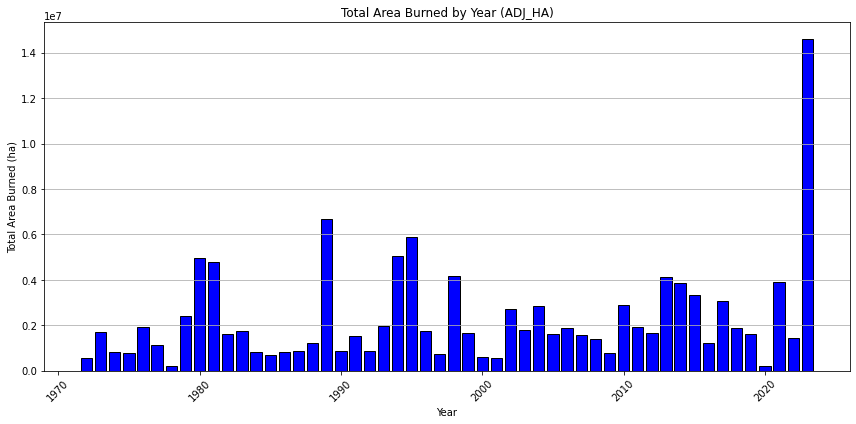

In [ ]:
# make bar graph of total ADJ_HA by year
df_grouped = df.groupby('YEAR')['ADJ_HA'].sum().reset_index()
plt.figure(figsize=(12, 6))
plt.bar(df_grouped['YEAR'], df_grouped['ADJ_HA'], color='blue', edgecolor='black')
plt.title("Total Area Burned by Year (ADJ_HA)")
plt.xlabel("Year")
plt.ylabel("Total Area Burned (ha)")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


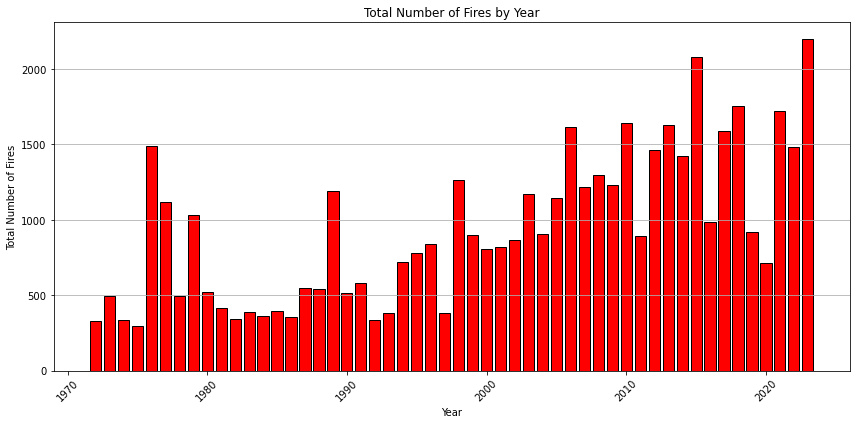

In [9]:
# total number of fires by year
df_grouped = df.groupby('YEAR')['NFIREID'].count().reset_index()
plt.figure(figsize=(12, 6))
plt.bar(df_grouped['YEAR'], df_grouped['NFIREID'], color='red', edgecolor='black')
plt.title("Total Number of Fires by Year")
plt.xlabel("Year")
plt.ylabel("Total Number of Fires")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

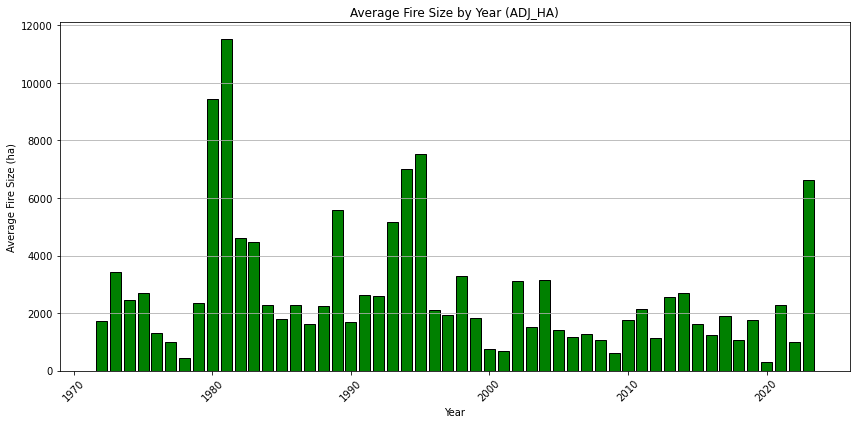

In [10]:
# make a plot average fire size by year
df_grouped = df.groupby('YEAR')['ADJ_HA'].mean().reset_index()
plt.figure(figsize=(12, 6))
plt.bar(df_grouped['YEAR'], df_grouped['ADJ_HA'], color='green', edgecolor='black')
plt.title("Average Fire Size by Year (ADJ_HA)")
plt.xlabel("Year")
plt.ylabel("Average Fire Size (ha)")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

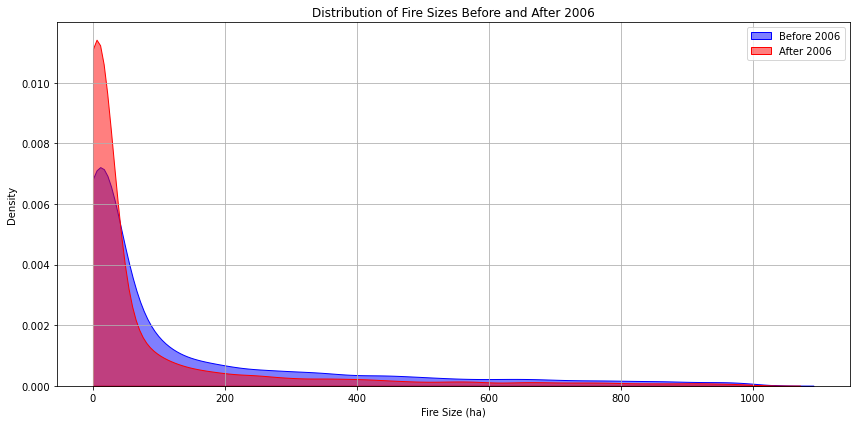

In [38]:
# make a distribution of the fire sizes make two distributions for up to 2006 and after 2007
# make kde overlay
# cut off for only values less than 200000
# restrict distribution to positive
import seaborn as sns
df_before_2007 = df[df['YEAR'] <= 2006]
df_after_2007 = df[df['YEAR'] > 2006]
df_before_2007 = df_before_2007[df_before_2007['ADJ_HA'] < 1000]
df_after_2007 = df_after_2007[df_after_2007['ADJ_HA'] < 1000]
plt.figure(figsize=(12, 6))
sns.kdeplot(df_before_2007['ADJ_HA'], color='blue', label='Before 2006', fill=True, alpha=0.5, clip=(0, None))
sns.kdeplot(df_after_2007['ADJ_HA'], color='red', label='After 2006', fill=True, alpha=0.5, clip=(0, None))
plt.title("Distribution of Fire Sizes Before and After 2006")
plt.xlabel("Fire Size (ha)")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



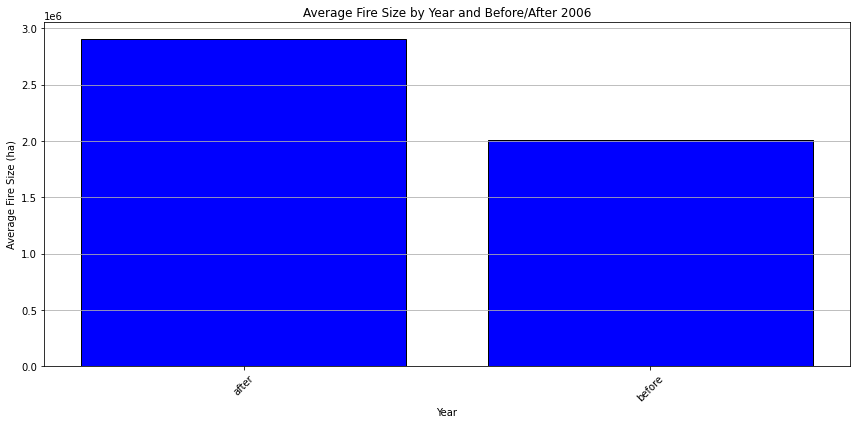

In [96]:
# group by year and before_after 2006 and sum the ADJ_HA
df_grouped = df.groupby(['YEAR', 'before_after_2006'])['ADJ_HA'].sum().reset_index()

# get the average fire size by year and before_after_2006
df_grouped_avg = df_grouped.groupby(['before_after_2006'])['ADJ_HA'].mean().reset_index()

# make a bar graph of the average fire size by year and before_after_2006
plt.figure(figsize=(12, 6))
plt.bar(df_grouped_avg['before_after_2006'], df_grouped_avg['ADJ_HA'], color='blue', edgecolor='black')
plt.title("Average Fire Size by Year and Before/After 2006")
plt.xlabel("Year")
plt.ylabel("Average Fire Size (ha)")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


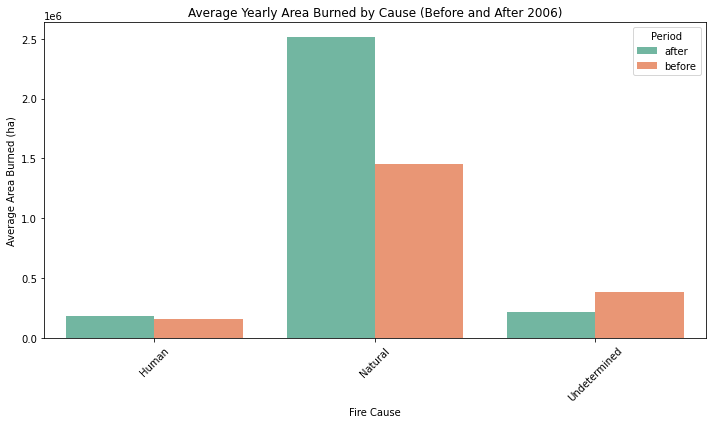

In [103]:
# group by year and before_after 2006 and sum the ADJ_HA
df_grouped_cause = df.groupby(['YEAR', 'before_after_2006', 'FIRECAUS'])['ADJ_HA'].sum().reset_index()

df_bar = df_grouped_cause.groupby(['before_after_2006', 'FIRECAUS'])['ADJ_HA'].mean().reset_index()

# visualize in a side by side bar plot
# Create a side-by-side bar plot
plt.figure(figsize=(10, 6))
sns.barplot(
    data=df_bar,
    x='FIRECAUS',
    y='ADJ_HA',
    hue='before_after_2006',
    palette='Set2'
)

# Add titles and labels
plt.title("Average Yearly Area Burned by Cause (Before and After 2006)")
plt.xlabel("Fire Cause")
plt.ylabel("Average Area Burned (ha)")
plt.xticks(rotation=45)
plt.legend(title="Period")
plt.tight_layout()

# Show the plot
plt.show()


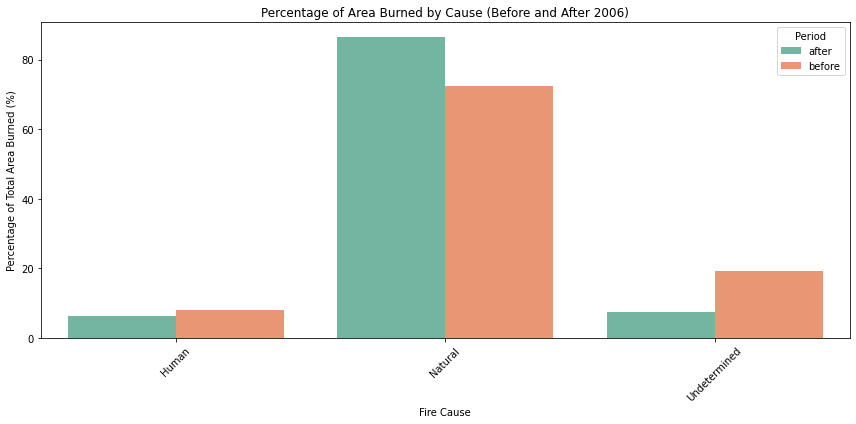

In [40]:
total_by_period = df_grouped.groupby('before_after_2006')['ADJ_HA'].transform('sum')

# Add a new column for percentages
df_grouped['PERCENTAGE'] = (df_grouped['ADJ_HA'] / total_by_period) * 100

# Create a side-by-side barplot with percentages
plt.figure(figsize=(12, 6))
sns.barplot(
    data=df_grouped,
    x='FIRECAUS',
    y='PERCENTAGE',
    hue='before_after_2006',
    palette='Set2'
)

# Add titles and labels
plt.title("Percentage of Area Burned by Cause (Before and After 2006)")
plt.xlabel("Fire Cause")
plt.ylabel("Percentage of Total Area Burned (%)")
plt.xticks(rotation=45)
plt.legend(title="Period")
plt.tight_layout()

# Show the plot
plt.show()